<a href="https://colab.research.google.com/github/kim-bo-saeng/dacon_jeju/blob/master/jeju_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### 라이브러리 가져오기

In [47]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

### 데이터 전처리

In [48]:
row_data = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/201901-202003.csv')
print(row_data.shape)
row_data.tail()

(24697792, 12)


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6
24697791,202003,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3


In [49]:
def grap_year(data):
  data = str(data)
  return int(data[:4])

def grap_month(data):
  data = str(data)
  return int(data[4:])

In [50]:
# 날짜 처리
data = row_data.copy()
data = data.fillna(1)
data['year'] = data['REG_YYMM'].apply(lambda x : grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x : grap_month(x))
data = data.drop(['REG_YYMM'], axis = 1)
print(data.shape)
data.tail()

(24697792, 13)


,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
24697787,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,2020,3
24697788,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,2020,3
24697789,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,2020,3
24697790,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,2020,3
24697791,충북,충주시,휴양콘도 운영업,충북,충주시,60s,1,5,3,194000,3,2020,3


In [51]:
# 데이터 정제
df = data.copy()
df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis = 1)

columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',	'AGE',	'SEX_CTGO_CD',	'FLC',	'year',	'month']
df = df.groupby(columns).sum().reset_index(drop=False)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057394 entries, 0 to 1057393
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   CARD_SIDO_NM  1057394 non-null  object
 1   STD_CLSS_NM   1057394 non-null  object
 2   HOM_SIDO_NM   1057394 non-null  object
 3   AGE           1057394 non-null  object
 4   SEX_CTGO_CD   1057394 non-null  int64 
 5   FLC           1057394 non-null  int64 
 6   year          1057394 non-null  int64 
 7   month         1057394 non-null  int64 
 8   CSTMR_CNT     1057394 non-null  int64 
 9   AMT           1057394 non-null  int64 
 10  CNT           1057394 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 88.7+ MB
None


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3


In [52]:
# 인코딩
dtypes = df.dtypes
encoders = {}

for column in df.columns:
  if str(dtypes[column]) == 'object':
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

df_num = df.copy()
for column in encoders.keys():
  encoder = encoders[column]
  df_num[column] = encoder.transform(df[column])

print(df_num.info())
df_num.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057394 entries, 0 to 1057393
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   CARD_SIDO_NM  1057394 non-null  int64
 1   STD_CLSS_NM   1057394 non-null  int64
 2   HOM_SIDO_NM   1057394 non-null  int64
 3   AGE           1057394 non-null  int64
 4   SEX_CTGO_CD   1057394 non-null  int64
 5   FLC           1057394 non-null  int64
 6   year          1057394 non-null  int64
 7   month         1057394 non-null  int64
 8   CSTMR_CNT     1057394 non-null  int64
 9   AMT           1057394 non-null  int64
 10  CNT           1057394 non-null  int64
dtypes: int64(11)
memory usage: 88.7 MB
None


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
1057389,16,40,16,6,2,5,2019,3,3,148000,4
1057390,16,40,16,6,2,5,2019,5,5,329800,7
1057391,16,40,16,6,2,5,2019,10,7,557800,7
1057392,16,40,16,6,2,5,2019,12,3,247800,3
1057393,16,40,16,6,2,5,2020,1,3,230400,3


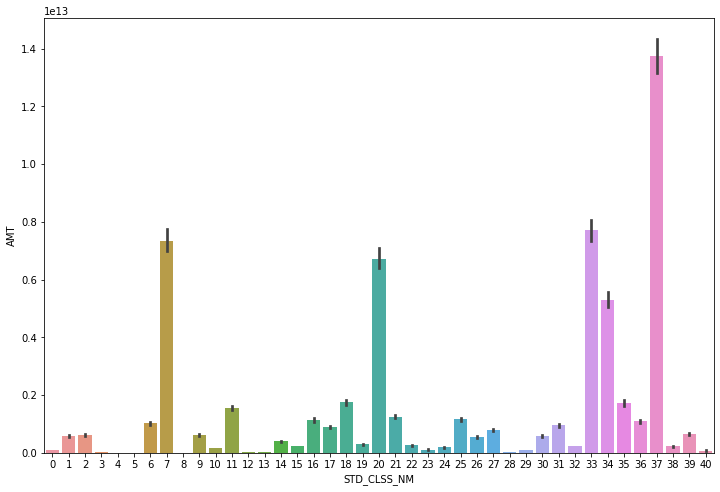

In [90]:
plt.figure(figsize = (12, 8))
sns.barplot(data = df_num, x = 'STD_CLSS_NM', y = 'AMT', estimator= np.sum)

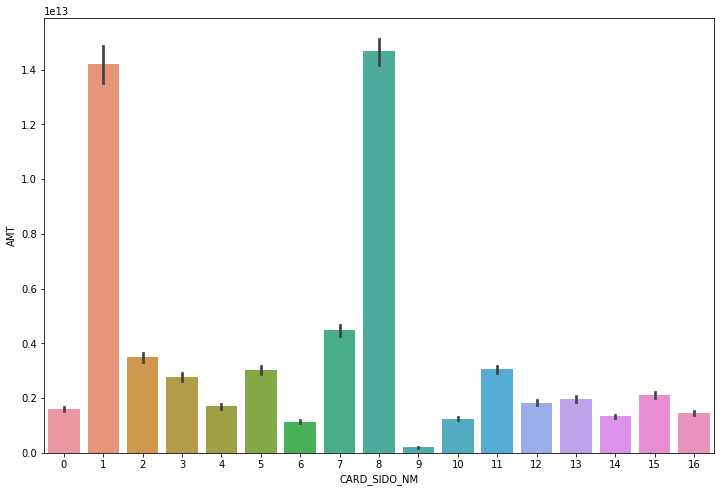

In [89]:
plt.figure(figsize = (12, 8))
sns.barplot(data = df_num, x = 'CARD_SIDO_NM', y = 'AMT', estimator= np.sum)

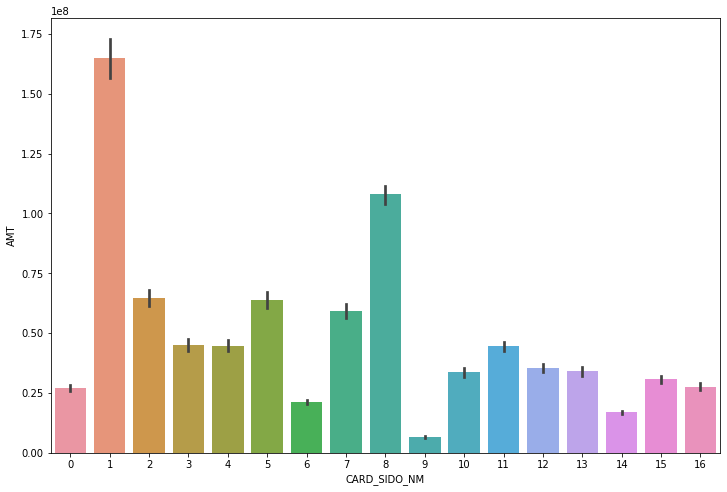

In [54]:
plt.figure(figsize = (12, 8))
sns.barplot(data = df_num, x = 'CARD_SIDO_NM', y = 'AMT')

In [72]:
a = df_num[['year', 'month','AMT']]
b = pd.pivot_table(a, index = ['year'], values='AMT', aggfunc = 'mean')
b

,AMT
year,
2019,5.673225e+07
2020,5.837500e+07


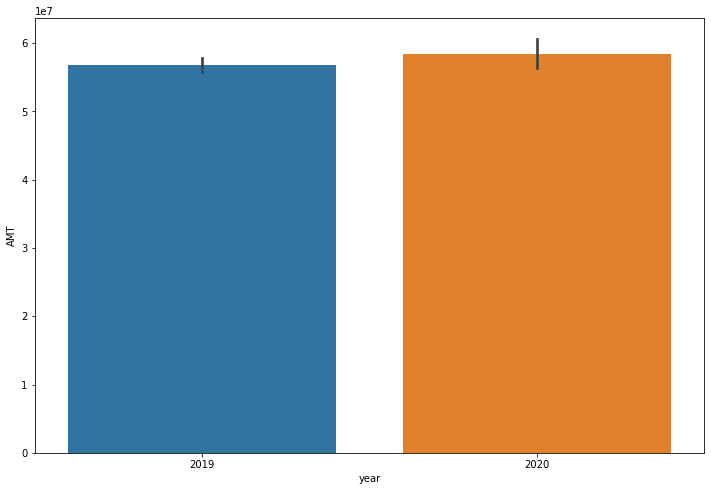

In [88]:
plt.figure(figsize = (12, 8))
sns.barplot(data = df_num, x = 'year', y = 'AMT')

In [59]:
sns.barplot?

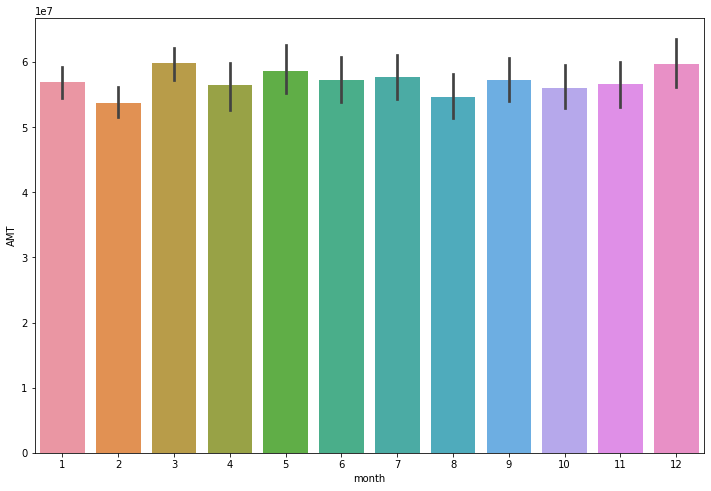

In [56]:
plt.figure(figsize = (12, 8))
sns.barplot(data = df_num, x = 'month', y = 'AMT')

In [57]:
row_data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


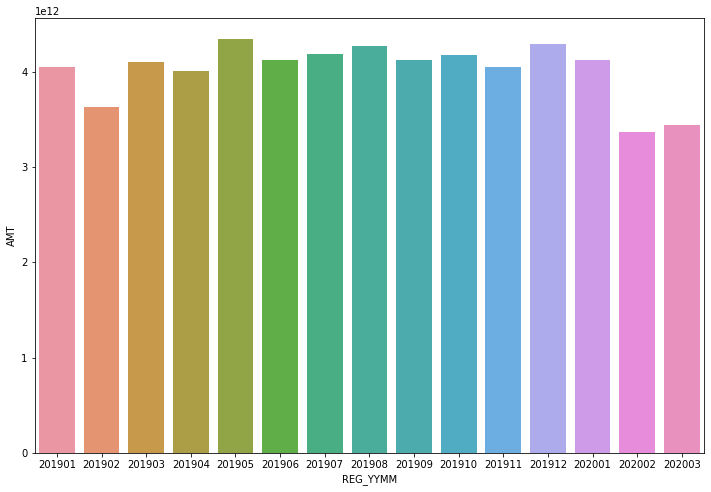

In [66]:
row_df = row_data.copy()
row_df = row_df.drop(['CARD_CCG_NM', 'HOM_CCG_NM','CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',	'AGE',	'SEX_CTGO_CD',	'FLC'], axis = 1)
row_df = row_df.groupby(['REG_YYMM']).sum().reset_index(drop=False)

plt.figure(figsize = (12, 8))
sns.barplot(data = row_df, x = 'REG_YYMM', y = 'AMT', estimator= np.sum )

### Feature Enginnering & Initial Modeling

In [ ]:
train_num = df_num.sample(frac = 1, random_state = 0)
train_features = train_num.drop(['CSTMR_CNT',	'AMT',	'CNT'], axis = 1)
train_target = np.log1p(train_num['AMT'])

### Hyperparamter Tuning & Cross Validation
 - Random Search(Coarse)

In [ ]:
n_estimators = 10 # 트리의 갯수는 나중에 천천히 올려보겠습니다.
num_epoch = 20    # 반복횟수는 일단 20번 
coarse_hyperparameters_list = [] # hyperparameter 탐색 결과를 리스트로 저장

# num_epoch 횟수만큼 랜덤 서치를 반복합니다.
for epoch in range(num_epoch):
    max_depth = np.random.randint(low = 50, high = 100)
    max_features = np.random.uniform(low = 0.5, high = 1.0)
    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1,
                                  random_state = 4)

    predict = cross_val_predict(model, train_features, train_target, cv = 20)
    y_predict = np.expm1(predict)

    score = mean_squared_log_error(train_num['AMT'], y_predict)
    score = np.sqrt(score)
    
    # hyperparameter 탐색 결과
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }
    coarse_hyperparameters_list.append(hyperparameters)
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

# coarse_hyperparameters_list를 Pandas의 DataFrame으로 변환합니다.
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)
coarse_hyperparameters_list.head(10)

 0 n_estimators = 10, max_depth = 96, max_features = 0.952405, Score = 0.75883
 1 n_estimators = 10, max_depth = 57, max_features = 0.815105, Score = 0.77495
 2 n_estimators = 10, max_depth = 95, max_features = 0.637907, Score = 0.81378
 3 n_estimators = 10, max_depth = 70, max_features = 0.810952, Score = 0.77495
 4 n_estimators = 10, max_depth = 76, max_features = 0.643323, Score = 0.81378
 5 n_estimators = 10, max_depth = 74, max_features = 0.706007, Score = 0.81378
 6 n_estimators = 10, max_depth = 72, max_features = 0.954307, Score = 0.75883
 7 n_estimators = 10, max_depth = 66, max_features = 0.950697, Score = 0.75883
 8 n_estimators = 10, max_depth = 65, max_features = 0.797324, Score = 0.77495
 9 n_estimators = 10, max_depth = 99, max_features = 0.870206, Score = 0.77495
10 n_estimators = 10, max_depth = 80, max_features = 0.640559, Score = 0.81378
11 n_estimators = 10, max_depth = 93, max_features = 0.673925, Score = 0.81378
12 n_estimators = 10, max_depth = 89, max_features =

,epoch,score,n_estimators,max_depth,max_features
0,0,0.758831,10,96,0.952405
7,7,0.758831,10,66,0.950697
6,6,0.758831,10,72,0.954307
19,19,0.758831,10,76,0.983919
8,8,0.774948,10,65,0.797324
16,16,0.774948,10,90,0.858006
1,1,0.774948,10,57,0.815105
18,18,0.774948,10,82,0.799245
12,12,0.774948,10,89,0.759333
15,15,0.774948,10,50,0.798504


### Model Tuning & Evaluation

In [ ]:
model = RandomForestRegressor(n_estimators = 20,
                              max_depth = 96,
                              max_features = 0.952405,
                              n_jobs = -1,
                              random_state = 4)
model.fit(train_features, train_target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=96, max_features=0.952405, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

### Conclusion & Discussion

In [ ]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=train_features.columns)
print(temp.shape)
temp.head()

(1658860, 8)


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month
0,0,0,0,1,1,1,2020,4
1,0,0,0,1,1,1,2020,7
2,0,0,0,1,1,2,2020,4
3,0,0,0,1,1,2,2020,7
4,0,0,0,1,1,3,2020,4


In [ ]:
# 예측
predict = model.predict(temp)
predict = np.expm1(predict)
temp['AMT'] = np.round(predict, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,0,0,4.910819e+08
1,202004,0,1,6.755726e+09
2,202004,0,2,1.832512e+09
3,202004,0,3,1.020002e+08
4,202004,0,4,9.810591e+07
...,...,...,...,...
1389,202007,16,36,1.881316e+09
1390,202007,16,37,2.836350e+10
1391,202007,16,38,2.005133e+08
1392,202007,16,39,1.181669e+09


In [ ]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [ ]:
# 제출 파일 만들기
submission = pd.read_csv('/gdrive/My Drive/data_analysis/jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('/gdrive/My Drive/data_analysis/jeju/submission_02.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,4.910819e+08
1,202004,강원,골프장 운영업,6.755726e+09
2,202004,강원,과실 및 채소 소매업,1.832512e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.020002e+08
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,9.810591e+07
